# Pulmonary Predictions with CNN

### Introduction

The intention of this project is to create an algorith which will accurately identify a pneumonia diagnosis from a chest x-ray. Never more than now have medical practitioners been bogged down by a never ending list of tasks which keep them from doing the important work of interacting with patients and thinking critically about intervetions. Any measure which would decrease time spent waiting around for results prior to intervetion is precious time for the patient, and an accurate measure has the potential to mitigate false diagnosis. 

Additionally, one study found that patients were a false negative rate (patient's whose pneumonia diagnosis is missed) at 11.4%, this is an alarming statistic especially in the times of COVID-19. Pneumonia is one of the most serious side effects of COVID-19 and if missed, could lead to poor outcomes in patients. 

This project seeks to improve efficiency and accuracy of diagnosis of pneumonia.

In [93]:
#begin by importing programs 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image 
import glob
from pathlib import Path
import seaborn as sns
import tensorflow as tf

tf.random.set_seed(16)
np.random.seed(11)

## Pathway Manipulation and Data Organization


First up, make the data reachable. 

In [94]:
print(os.listdir("../input"))

['chest-xray-pneumonia']


In [95]:
#explore main directory
mainDIR = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray')
print(mainDIR)

['val', 'train', '.DS_Store', 'test']


In [96]:
#create paths to each individual folder 
train_folder = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
val_folder = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')
test_folder = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')

In [97]:
#train data pathways
normal_cases_dir = train_folder / 'NORMAL'
pneu_cases_dir = train_folder / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneu_cases_dir.glob('*.jpeg')

train_data = []

#append data to list
for img in normal_cases:
    train_data.append((img,0))
    
for img in pneumonia_cases:
    train_data.append((img, 1))

#convert to pandas dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

#shuffle
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [98]:

print(train_data.shape)
train_data.head()

(5216, 2)


,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,0
1,../input/chest-xray-pneumonia/chest_xray/chest...,1
2,../input/chest-xray-pneumonia/chest_xray/chest...,0
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,1


In [99]:
#validation data pathways
normal_cases_dir = val_folder / 'NORMAL'
pneu_cases_dir = val_folder / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneu_cases_dir.glob('*.jpeg')

val_data = []

#append data to list
for img in normal_cases:
    val_data.append((img,0))
    
for img in pneumonia_cases:
    val_data.append((img, 1))

#convert to pandas dataframe
val_data = pd.DataFrame(val_data, columns=['image', 'label'], index=None)

#shuffle
val_data = val_data.sample(frac=1.).reset_index(drop=True)

In [100]:
print(val_data.shape)
val_data.head()

(16, 2)


,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,0
1,../input/chest-xray-pneumonia/chest_xray/chest...,0
2,../input/chest-xray-pneumonia/chest_xray/chest...,0
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,1


In [101]:
#test data pathways
normal_cases_tdir = test_folder / 'NORMAL'
pneu_cases_tdir = test_folder / 'PNEUMONIA'

normal_tcases = normal_cases_tdir.glob('*.jpeg')
pneumonia_tcases = pneu_cases_tdir.glob('*.jpeg')

test_data = []

#append data to list
for img in normal_tcases:
    test_data.append((img,0))
    
for img in pneumonia_tcases:
    test_data.append((img, 1))

#convert to pandas dataframe
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)

#shuffle
test_data = test_data.sample(frac=1.).reset_index(drop=True)

In [102]:
print(test_data.shape)
test_data.head()

(624, 2)


,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,1
1,../input/chest-xray-pneumonia/chest_xray/chest...,1
2,../input/chest-xray-pneumonia/chest_xray/chest...,1
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,0


After doing this it looks like we have the following:

* 5,216 training datapoints
* 16 validation datapoints
* 624 test datapoints 

Which is:

*  89% Train
*  .2% Validation
*  10% Test 

## Visualization & Class Balance

I'd like to explore a little more about the data now and make sure our images are processed appropriately (size and colorscale). 

[Text(0, 0, 'Normal'), Text(0, 0, 'Pneumonia')]

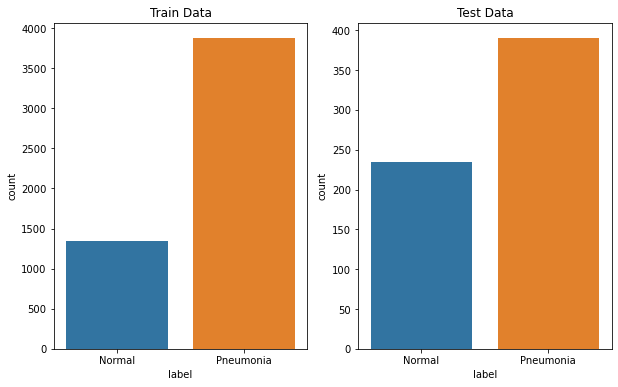

In [103]:
#how many cases each? 

f = plt.figure(figsize=(10,6))

a1 = f.add_subplot(1,2,1)
sns.countplot(train_data.label, ax = a1)
a1.set_title('Train Data')
a1.set_xticklabels(['Normal', 'Pneumonia'])

a2 = f.add_subplot(1,2,2)
sns.countplot(test_data.label, ax=a2)
a2.set_title('Test Data')
a2.set_xticklabels(['Normal', 'Pneumonia'])

As we can observe above the information is quite unbalanced (other than the valdiation data, which is a small sample). This is not uncommon in medical data and we can adjust this later depending on how our model plays out. 

Let's visualize some images!

Text(0.5, 1.0, 'Normal')

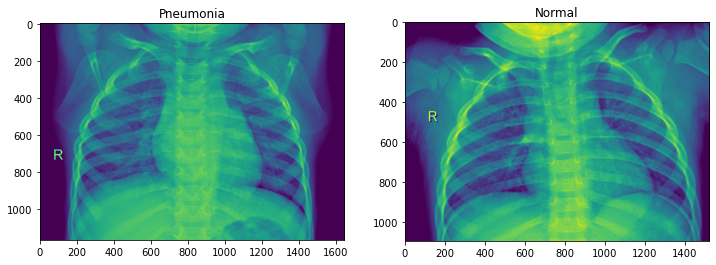

In [104]:
f = plt.figure(figsize=(12,8))

a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(Image.open(train_data.image[0]))
a1.set_title('Pneumonia')

a2 = f.add_subplot(1,2,2)
img_plot = plt.imshow(Image.open(train_data.image[2]))
a2.set_title('Normal')

As seen above these images are not easily distinguishable with the naked eye - that's what we're trying to create the algorithm for!

## Normalization and Image Processing

The next step is normalizing the data and making the images smaller to perform the neural network analysis. In order to decide what size our images should be, I'll find the smallest image in the dataset and change the sizes all to that size. 

In [105]:
#make a list with each image size 
shapes = []

for x in range(0,5215):
    shapes.append(plt.imread(train_data.image[x]).shape)

In [106]:
#find the smallest one
min(shapes)

(127, 384, 3)

The smallest image in the training data is 127x384, so we'll use that size for the rest of the images. 

In [107]:
#importing necessary programs 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 
from scipy import ndimage 

In [108]:
#scale images
train_dir = ImageDataGenerator(rescale=1./255)
val_dir = ImageDataGenerator(rescale=1./255)
test_dir = ImageDataGenerator(rescale=1./255)

In [109]:
#Make Directories 
train_gen = train_dir.flow_from_directory(train_folder, target_size=(127,384), batch_size = 20, class_mode='binary')
val_gen = val_dir.flow_from_directory(val_folder, target_size=(127,384), batch_size=10, class_mode='binary')
test_gen = test_dir.flow_from_directory(test_folder, target_size=(127,384), batch_size=20, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Modeling

In [110]:
from keras import layers 
from keras import models 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential 

# CNN model 

model_1 = Sequential()

#Convolution
model_1.add(Conv2D(32, (3,3), activation ='relu', input_shape=(127, 384, 3)))

#Pooling
model_1.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 2 
model_1.add(Conv2D(64, (3,3), activation='relu'))

#Pooling Layer 2 
model_1.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 3
model_1.add(Conv2D(128, (3,3), activation='relu'))

#Pooling again
model_1.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 4
model_1.add(Conv2D(128, (3,3), activation='relu'))

#Flattening
model_1.add(Flatten())

#Add Dense Layers 
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

In [111]:
#Compile

from keras import optimizers 

model_1.compile(loss='binary_crossentropy',
           optimizer=optimizers.RMSprop(lr=1e-4),
           metrics=['acc'])

In [112]:
history = model_1.fit_generator(train_gen,
                           steps_per_epoch=100,
                           epochs=20,
                           validation_data=val_gen,
                           validation_steps=50)

Epoch 1/20
100/100 [==============================] - 21s 208ms/step - loss: 0.3624 - acc: 0.8442 - val_loss: 0.6268 - val_acc: 0.6875
Epoch 2/20
100/100 [==============================] - 22s 221ms/step - loss: 0.1574 - acc: 0.9395
Epoch 3/20
100/100 [==============================] - 21s 208ms/step - loss: 0.1413 - acc: 0.9484
Epoch 4/20
100/100 [==============================] - 20s 203ms/step - loss: 0.1089 - acc: 0.9560
Epoch 5/20
100/100 [==============================] - 20s 203ms/step - loss: 0.0864 - acc: 0.9689
Epoch 6/20
100/100 [==============================] - 21s 205ms/step - loss: 0.0908 - acc: 0.9635
Epoch 7/20
100/100 [==============================] - 20s 200ms/step - loss: 0.0867 - acc: 0.9654
Epoch 8/20
100/100 [==============================] - 21s 212ms/step - loss: 0.0712 - acc: 0.9765
Epoch 9/20
100/100 [==============================] - 21s 207ms/step - loss: 0.0664 - acc: 0.9739
Epoch 10/20
100/100 [==============================] - 21s 212ms/step - loss: 0.0

In [113]:
test_1_acc = model_1.evaluate_generator(test_gen, steps=50)
print('The accuracy of this test is:', test_1_acc[1]*100,'%')

The accuracy of this test is: 77.40384340286255 %


Ok, 77% isn't too bad. However if we examine the training data we were getting 98% accuracy in some cases so it seems we've got some overtraining going on. Let's add a few dropout layers and see how it looks. 

In [114]:
from keras.layers import Dropout

model_2 = Sequential()

#Convolution
model_2.add(Conv2D(32, (3,3), activation ='relu', input_shape=(127, 384, 3)))

#Pooling
model_2.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 2 
model_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))

#Dropout 1
model_2.add(Dropout(0.35))

#Pooling Layer 2 
model_2.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 3
model_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))

#Dropout 2
model_2.add(Dropout(0.35))

#Pooling again
model_2.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 4
model_2.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Dropout 3
model_2.add(Dropout(0.35))

#Flattening
model_2.add(Flatten())

#Add Dense Layers 
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [115]:
model_2.compile(loss='binary_crossentropy',
           optimizer=optimizers.RMSprop(lr=1e-4),
           metrics=['acc'])

In [116]:
history_2 = model_2.fit_generator(train_gen,
                           steps_per_epoch=100,
                           epochs=30,
                           validation_data=val_gen,
                           validation_steps=50)

Epoch 1/30
100/100 [==============================] - 21s 210ms/step - loss: 0.4315 - acc: 0.8390 - val_loss: 0.4372 - val_acc: 0.8125
Epoch 2/30
100/100 [==============================] - 21s 211ms/step - loss: 0.1544 - acc: 0.9494
Epoch 3/30
100/100 [==============================] - 21s 206ms/step - loss: 0.1243 - acc: 0.9550
Epoch 4/30
100/100 [==============================] - 20s 204ms/step - loss: 0.0975 - acc: 0.9689
Epoch 5/30
100/100 [==============================] - 21s 214ms/step - loss: 0.0827 - acc: 0.9719
Epoch 6/30
100/100 [==============================] - 20s 197ms/step - loss: 0.0935 - acc: 0.9719
Epoch 7/30
100/100 [==============================] - 21s 205ms/step - loss: 0.0810 - acc: 0.9715
Epoch 8/30
100/100 [==============================] - 21s 207ms/step - loss: 0.0718 - acc: 0.9734
Epoch 9/30
100/100 [==============================] - 20s 203ms/step - loss: 0.0691 - acc: 0.9755
Epoch 10/30
100/100 [==============================] - 20s 204ms/step - loss: 0.0

In [117]:
test_4_acc = model_2.evaluate_generator(test_gen, steps=50)
print('The accuracy of this test is:', test_4_acc[1]*100,'%')

The accuracy of this test is: 74.5192289352417 %


Somehow adding the dropout layers made out accuracy go down. 

<img src="https://media.giphy.com/media/y1YqNut2cuOGY/giphy.gif">

I'll try balancing the data now.

## Balancing the training data

In [118]:
train_data.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

In [119]:
pneu_count = train_data.label.value_counts(1)[1]
norm_count = train_data.label.value_counts(1)[0]
weight_for_0 = (1/norm_count)
weight_for_1 = (1/pneu_count)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [120]:
history = model_2.fit_generator(train_gen,
                                steps_per_epoch=100,
                                epochs=30,
                                validation_data=val_gen,
                                validation_steps=50,
                               class_weight = class_weight)

Epoch 1/30
100/100 [==============================] - 21s 208ms/step - loss: 0.0352 - acc: 0.9945 - val_loss: 0.3604 - val_acc: 0.8125
Epoch 2/30
100/100 [==============================] - 20s 198ms/step - loss: 0.0378 - acc: 0.9945
Epoch 3/30
100/100 [==============================] - 21s 207ms/step - loss: 0.0487 - acc: 0.9930
Epoch 4/30
100/100 [==============================] - 21s 207ms/step - loss: 0.0311 - acc: 0.9950
Epoch 5/30
100/100 [==============================] - 21s 208ms/step - loss: 0.0382 - acc: 0.9935
Epoch 6/30
100/100 [==============================] - 21s 210ms/step - loss: 0.0213 - acc: 0.9970
Epoch 7/30
100/100 [==============================] - 20s 198ms/step - loss: 0.0254 - acc: 0.9970
Epoch 8/30
100/100 [==============================] - 20s 202ms/step - loss: 0.0240 - acc: 0.9960
Epoch 9/30
100/100 [==============================] - 21s 209ms/step - loss: 0.0263 - acc: 0.9960
Epoch 10/30
100/100 [==============================] - 19s 194ms/step - loss: 0.0

In [121]:
test_4_acc = model_2.evaluate_generator(test_gen, steps=50)
print('The accuracy of this test is:', test_4_acc[1]*100,'%')

The accuracy of this test is: 75.64102411270142 %


Hmm, it doesn't seem like balancing the classes made much of a difference either. 

Next, let's try using a well known, pre-trained convulusion in our neural network.

## Pretrained CNN Base

The following is called the VGG-19 network, which was trained on 1.2 million images. 

In [122]:
#import network and create CNN base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                include_top = False,
                input_shape=(127,384,3))

In [123]:
#build the dense layer of the model w/ cnn_base as convolutional model 
model_pt = models.Sequential()
model_pt.add(cnn_base)
model_pt.add(layers.Flatten())
model_pt.add(layers.Dense(132, activation='relu'))
model_pt.add(layers.Dense(1, activation='sigmoid'))

In [124]:
#checking trainable layers and trainable weights 
for layer in model_pt.layers:
    print(layer.name, layer.trainable)
    
print(len(model_pt.trainable_weights))

vgg19 True
flatten_8 True
dense_19 True
dense_20 True
36


In [125]:
#we will now "freeze" the layer by setting the trainable attribute to false

cnn_base.trainable = False 

In [126]:
#repeat this for a sanity check 
for layer in model_pt.layers:
    print(layer.name, layer.trainable)
    
print(len(model_pt.trainable_weights))

vgg19 False
flatten_8 True
dense_19 True
dense_20 True
4


In [127]:
#compile model 
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

model_pt.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics= METRICS)

In [128]:
#fit

history = model_pt.fit_generator(train_gen,
                               steps_per_epoch=27,
                               epochs=7,
                               validation_data=val_gen,
                               validation_steps=10,
                             class_weight=class_weight)

Epoch 1/7
27/27 [==============================] - 6s 222ms/step - loss: 1.0377 - accuracy: 0.7630 - precision: 0.9035 - recall: 0.7649 - val_loss: 0.5131 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/7
27/27 [==============================] - 6s 210ms/step - loss: 0.7073 - accuracy: 0.8907 - precision: 0.9717 - recall: 0.8750
Epoch 3/7
27/27 [==============================] - 5s 186ms/step - loss: 0.5309 - accuracy: 0.9074 - precision: 0.9814 - recall: 0.8959
Epoch 4/7
27/27 [==============================] - 5s 201ms/step - loss: 0.4614 - accuracy: 0.9019 - precision: 0.9784 - recall: 0.8894
Epoch 5/7
27/27 [==============================] - 6s 213ms/step - loss: 0.4103 - accuracy: 0.9259 - precision: 0.9868 - recall: 0.9146
Epoch 6/7
27/27 [==============================] - 5s 194ms/step - loss: 0.3375 - accuracy: 0.9278 - precision: 0.9847 - recall: 0.9214
Epoch 7/7
27/27 [==============================] - 5s 200ms/step - loss: 0.3640 - accuracy: 0.919

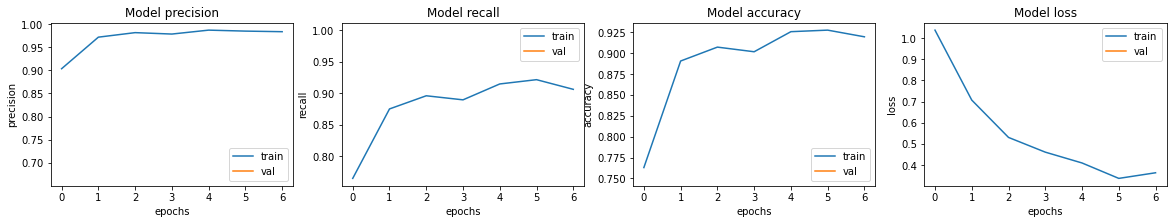

In [129]:
#visualizing training accruacy and loss 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [130]:
loss, acc, prec, rec =model_pt.evaluate(test_gen)

32/32 [==============================] - 6s 174ms/step - loss: 0.3634 - accuracy: 0.8365 - precision: 0.8051 - recall: 0.9744


83%! This is much more in the range I'm looking for. Next, I'll do a little fine tuning of the model to try and increase the accuracy even further. 

## Fine Tuning

In [131]:
#first, unfreeze the base.

cnn_base.trainable = True

In [132]:
#iterate thru the layers 
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

In [133]:
#remodel 
model_ft = models.Sequential()
model_ft.add(cnn_base)
model_ft.add(layers.Flatten())
model_ft.add(layers.Dense(132, activation='relu'))
model_ft.add(layers.Dense(1, activation='sigmoid'))

In [134]:
model_ft.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=1e-4),
             metrics=METRICS)

In [135]:
batch_size = 50

history = model_ft.fit_generator(train_gen,
                               steps_per_epoch=27,
                               epochs=7,
                               validation_data=val_gen,
                               validation_steps=10,
                             class_weight=class_weight)

Epoch 1/7
27/27 [==============================] - 6s 231ms/step - loss: 0.9827 - accuracy: 0.8004 - precision: 0.8548 - recall: 0.8919 - val_loss: 0.3791 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 2/7
27/27 [==============================] - 5s 192ms/step - loss: 0.3792 - accuracy: 0.9104 - precision: 0.9811 - recall: 0.8988
Epoch 3/7
27/27 [==============================] - 6s 206ms/step - loss: 0.3327 - accuracy: 0.9333 - precision: 0.9843 - recall: 0.9261
Epoch 4/7
27/27 [==============================] - 5s 196ms/step - loss: 0.3459 - accuracy: 0.9296 - precision: 0.9866 - recall: 0.9177
Epoch 5/7
27/27 [==============================] - 5s 201ms/step - loss: 0.3596 - accuracy: 0.9328 - precision: 0.9762 - recall: 0.9318
Epoch 6/7
27/27 [==============================] - 5s 200ms/step - loss: 0.1716 - accuracy: 0.9574 - precision: 0.9896 - recall: 0.9526
Epoch 7/7
27/27 [==============================] - 6s 225ms/step - loss: 0.2219 - accuracy: 0.966

In [136]:
loss, acc, prec, rec =model_ft.evaluate(test_gen)

32/32 [==============================] - 6s 172ms/step - loss: 0.3627 - accuracy: 0.9135 - precision: 0.9058 - recall: 0.9615


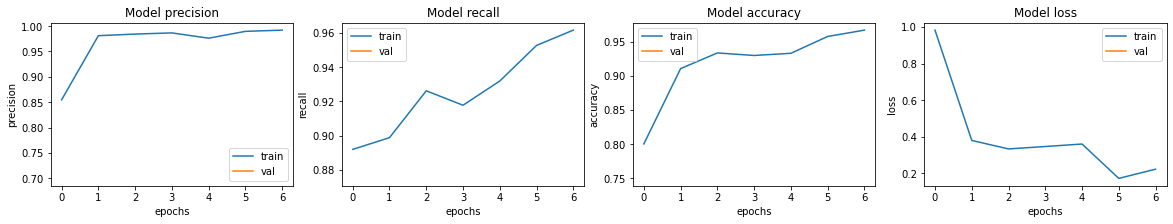

In [137]:
#visualizing training accruacy and loss 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

91 % !!!!!!!!! 

<img src="https://media.giphy.com/media/TlK63Eu7Dwok2j8TgfS/giphy.gif">

I'll keep this as the final model. 

## Performance Breakdown

### Accuracy, precision & recall

In [138]:
from sklearn.metrics import accuracy_score, confusion_matrix
loss, acc, prec, rec =model_ft.evaluate(test_gen)

32/32 [==============================] - 5s 171ms/step - loss: 0.3627 - accuracy: 0.9135 - precision: 0.9058 - recall: 0.9615


### ROC curve & AUC

Found 624 images belonging to 2 classes.


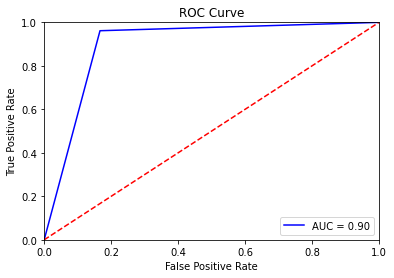

In [139]:
import sklearn.metrics as metrics

test_gen_final = test_dir.flow_from_directory(test_folder, target_size=(127,384),batch_size=624, class_mode='binary')
test_data, test_labels = next(test_gen_final)
preds = model_ft.predict(test_data)

fpr, tpr, threshold = metrics.roc_curve(test_labels, np.round(preds))
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix

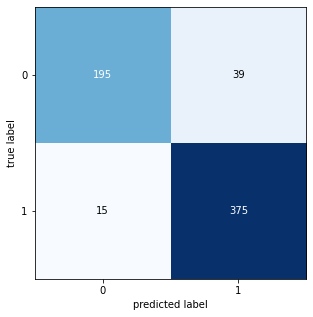


TEST METRICS ----------------------
Accuracy: 91.34615384615384%
Precision: 90.57971014492753%
Recall: 96.15384615384616%
F1-score: 93.28358208955223
Specificity: 83.33333333333334%
Sensitivity: 96.15384615384616%


In [140]:
acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

#confusion matrix
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
sensitivity = recall
specificity = tn/(tn+fp)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print('Specificity: {}%'.format(specificity))
print('Sensitivity: {}%'.format(recall))

## Performance Measures Explanation

#### **1. Accuracy (91%)**
This is the one most people are intuitively familiar with. Accuracy represents the ratio of correctly predicted obersations to the total observations. This is the same measure all our test were graded on in school, etc. 


#### **2. Precision or Positive Predictive Value (90%):** 
Precision is the ratio of correctly predicted positive observations to all observations to total predicted positive observations (re: true positives / true positives + false positives ). It answers the question "Of all the positive identifications, what proportion were actuall correct?". In our case, 90% of the time we told someone they had pneumonia, they actually did. 


#### **3. Recall or Sensitivity (96%):** 
Recall is the ratio of correct predictions and the total number of correct items in the set (re: true positives/ true positives + false negatives). Sensitivity is a good measure of how many false negatives you had, or in our case, a measure of how many people will be told they don't have pneumonia when they actually do. For us, we will detect 96% of pneumonia cases.


#### **4. F1 Score (93):** 
The F1 score is a combination of the precision and recall scores as follows: 2 * (precision * recall)/(precision + recall). It gives equal wait to both measures. This model's F1 score is 93 which is excellent. It demonstrates good and balanced precision and recall.

#### **5. ROC curves and AUC score (.90):**
A Reciever Operator Characterstic (ROC) curve illustrates the true positive rate against the false positive rate. This graph gives us a tradeoff between these two and the Area Under the Curve (AUC) gives us a single metric to evaluate this. An AUC of 1 is a perfect classifier and an AUC of 0.5 is considered "Worthless" because there is a 50/50 chance of getting a true/flase positive. This model scored an .87, which is considered quite good. 

#### 6. Specificity (83%):

Specificity refers the proportion of negatives which are truly negative (re: the number of patients without the diagnosis who test negative). It's a good measure of false positives and is calculated as follows: True Negatives / True Negatives + False Positives. This model's specificity is 83% which is considered excellent. With this specific model I wuld prefer to have a higher sensitivity and am not as worried about specificity, which I will explain below. 

#### 7. Confusion Matrix:

This confusion matrix is especially important for our data. In the top left and bottom right corners you'll see the true negative and true positive representation (respectively). The other two corners represent the false positive (top right) and false negative (bottom left). Depending on the situation you may prefer for your model to lean towards one of these categories. In most medical testing you would prefer that your incorrectly identified labels to have more false positives than false negatives as the implications of an incorrect prelimary diagnosis are much less malignant than a missed diagnosis. 

Our model produced 54 incorrect predictions, only 15 (27% of the incorrect predictions and 2.4% of whole) of which were false negatives. This means that our model arguably gives us a favorable outcome 97.6% of the time. 

## Conclusion

Overall, this model gives us safe, reliable readings of patient chest xray screens. This leaves the practitioners with quicker results for quicker action as well as more time to spend with their patients.

## Further Recommendations

1. Train a similar model on adult images 

2. Continue to search for diagnosis processes worthy of streamlining through machine learning to improve efficiency and accuracy in healthcare.